# UofT Routing using Beam Search Algorithm

In [1]:
import osmnx
from optalgotools.routing import (cost, draw_route, get_child, randomized_search)
from optalgotools.structures import Node, Solution
from itertools import islice
from sys import getsizeof
from time import process_time
import heapq
import numpy as np
import matplotlib.pyplot as plt

### Set points of interest

In [3]:
# Set up King's College Cir, Toronto, ON as a reference
reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)

# Set up the points
origin = (43.664527, -79.392442) # King Edward VII Equestrian Statue
destination = (43.659659, -79.397669) # Bahen Centre for Information Technology at UofT

# Get the osmid of the nearest nodes to the points
origin_id = osmnx.distance.nearest_nodes(G, origin[1], origin[0])
destination_id = osmnx.distance.nearest_nodes(G, destination[1], destination[0])

# Convert the source and destination nodes to Node
origin = Node(graph=G, osmid=origin_id)
destination = Node(graph=G, osmid=destination_id)

# Beam Search Algorithm

In [4]:
def get_beam(G, beam, n=20):
    new_beam = []
    for route in beam:
        neighbours = list(islice(get_child(G, route), n))
        new_beam.extend(neighbours)
    return new_beam

In [5]:
def Beam_Search(G, origin, destination, k=10, n=20):
    start_time = process_time()
    # Initialize
    seen = set()
    costs = []
    # Generate random initial beam
    beam = [randomized_search(G, origin.osmid, destination.osmid) for _ in range(k)]

    # the seen routes must be converted to a tuple to be hashable to be stored in a set
    for route in beam:
        seen.add(tuple(route))

    pool = []
    children = get_beam(G, beam, n)
    costs.append([cost(G, r) for r in beam])
    for r in children:
        if tuple(r) in seen:
            continue
        else:
            pool.append(r)
            seen.add(tuple(r))
    pool += beam
    space_required = getsizeof(pool)
    last_beam = None
    while beam != last_beam:
        last_beam = beam
        beam = heapq.nsmallest(k, pool, key=lambda r: cost(G, r))

        for route in beam:
            seen.add(tuple(route))

        pool = []
        children = get_beam(G, beam, n)
        costs.append([cost(G, r) for r in beam])
        for r in children:
            if tuple(r) in seen:
                continue
            else:
                pool.append(r)
                seen.add(tuple(r))
        pool += beam
        space_required = (
            getsizeof(pool) if getsizeof(pool) > space_required else space_required
        )
    route = min(beam, key=lambda r: cost(G, r))
    end_time = process_time()
    return Solution(
        route, end_time - start_time, space_required, np.rot90(costs))

### Find the shortest route

Cost: 817.379 m
Process time: 182.625 s
Space required: 1656 bytes


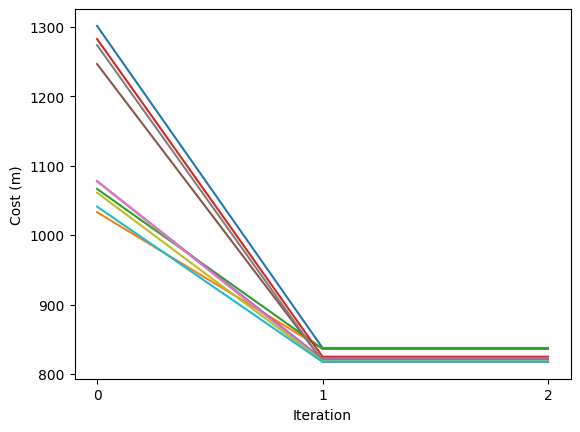

In [6]:
solution = Beam_Search(G, origin, destination, k=10, n=20)
route = solution.result
print(f"Cost: {cost(G,route)} m")
print(f"Process time: {solution.time} s")
print(f"Space required: {solution.space} bytes")
for c in solution.explored:
    plt.plot(c)
plt.xticks(list(range(len(solution.explored[0]))))
plt.ylabel("Cost (m)")
plt.xlabel("Iteration")
plt.show()

### Visualize the shortest route

In [7]:
draw_route(G,route)